## Importing data

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import math

In [16]:
df = pd.read_csv("/home/DAVIDSON/brwiedenbeck/public/NLP/quora.csv")

#### Train-test-validation split

We split the data 80%-20% for the train and test sets, and further split the train set 80%-20% to obtain a validation set. By performing a stratified train-test split, we were able to preserve the same proportions of examples in each class as observed in the original dataset. 

In [17]:
train_data, test_data = train_test_split(df, train_size=0.80, stratify = df['target'], random_state=42)

In [18]:
train_data, val_data = train_test_split(train_data, train_size=0.80, stratify = train_data['target'], random_state=42)

Upon inspection below, we see that we have a very large dataset with over 800,000 training samples. 

In [12]:
print("TRAIN DATA")
print(train_data.shape)
print(train_data['target'].value_counts())
print("VALIDATION DATA")
print(val_data.shape)
print(val_data['target'].value_counts())
print("TEST DATA")
print(test_data.shape)
print(test_data['target'].value_counts())

TRAIN DATA
(835917, 3)
0    784199
1     51718
Name: target, dtype: int64
VALIDATION DATA
(208980, 3)
0    196050
1     12930
Name: target, dtype: int64
TEST DATA
(261225, 3)
0    245063
1     16162
Name: target, dtype: int64


## Preprocessing Data

In terms of preprocessing, we need to tokenize the questions (first column of the dataframe) and generate word embeddings that can then be fed into the neural network. We decided to use Stanford's GloVe embedding with 100 dimensions. 

#### Download GloVe

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

#### Create dictionary of GloVe embeddings

In [22]:
# "embedding" is a dictionary of raw GloVe embeddings of words
f = open("glove.6B.100d.txt")
lines = f.readlines()
embedding = dict()
for line in lines:
        parts = line.split()
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')

#### Preprocessing Function

The function below takes in a single question, tokenizes it, creates a vector of length 100 repreenting the glove embedding for each token, and adds all embedding vectors to a matrix. The final output matrix has shape 'number of tokens × 100' (each row is an embedding vector for each word in the question) and is therefore a GloVE representation for the question.  

In [21]:
def glove_embedding(data):
    
    tokens = text_to_word_sequence(data)
    matrix = np.zeros((len(tokens), 100))
    for index, word in enumerate(tokens):
        vector_rep = embedding.get(word)
        if vector_rep is not None:
            matrix[index] = vector_rep
    matrix = np.array(matrix, dtype=object)
    return matrix

## Data Generators

Since the dataset is very large, it was not possible to hold all embeddings in memory at once. We faced a lot of memory issues and tried many different approaches of resolution before deciding to use data generators. Initially, we split the training dataset into 12 batches, generated GloVe embeddings for each batch one at a time, and saved the embeddings to 12 different files. We also split the train labels into 12 batches to match their respective questions. We then tried to load each batch of training data one at a time when training the model, however, were still exceeding memory. Despite using gc.collect() and tf.keras.backend.clear_session() to empty memory, we kept getting stuck after a certain number of batches had been loaded. Hence we tried the alternate approach of using data generators to feed data into Keras in real-time while training the model. 

#### Generator for training data

Our data generator splits the dataset into batches, generates embeddings for each batch by calling the glove_embedding() function, pads sequences such that all questions in a batch are of the same length, and then feeds the questions and their targets one at a time into the neural network. 

In [46]:
batch_size = 256

def train_gen(train_data):
    num_batches = math.ceil(len(train_data) / batch_size)
    while True: 
        train_data = train_data.sample(frac=1.) # shuffle the data
        for i in range(num_batches):
            train_questions = []
            batch = train_data.iloc[i * batch_size: (i + 1) * batch_size, 1] # extract one batch 
            for question in batch:
                train_questions.append(glove_embedding(question)) # generate GloVe embeddings for the batch 
            train_questions = np.array(train_questions, dtype = object)
            train_questions = pad_sequences(train_questions, padding = 'post', dtype = 'float32', maxlen = 200)
            yield train_questions, np.array(train_data["target"][i * batch_size:(i + 1) * batch_size])

In [47]:
train_generator = train_gen(train_data)

#### Generator for validation data

In [48]:
# Generator for validation data
batch_size = 256
def val_gen(val_data):
    num_batches = math.ceil(len(val_data) / batch_size)
    while True: 
        for i in range(num_batches):
            val_questions = []
            batch = val_data.iloc[i * batch_size: (i + 1) * batch_size, 1]
            for question in batch:
                val_questions.append(glove_embedding(question))
        val_questions = np.array(val_questions, dtype = object)
        val_questions = pad_sequences(val_questions, padding = 'post', dtype = 'float32', maxlen = 200)
        yield val_questions, np.array(val_data["target"][i * batch_size:(i + 1) * batch_size])

In [49]:
val_generator = val_gen(val_data)

## LSTM Model

After experiemnting with values of 32 and 64, we found that an LSTM layer with 128 units works best. We therefore built a model with an LSTM layer of 128 units, a dense layer with relu activations, a dropout of 0.2, and an output layer with one node and sigmoid activations to perform classification. 

In [50]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dense(64, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [51]:
model.compile(optimizer = "adam", loss="binary_crossentropy", metrics=['accuracy'])

## Training

In [27]:
# Train for 5 epochs 
history = model.fit(train_generator, epochs = 5, steps_per_epoch = 1000, verbose = 1)

Epoch 1/5
1000/1000 [==============================] - 267s 264ms/step - loss: 0.2366 - accuracy: 0.9392
Epoch 2/5
1000/1000 [==============================] - 265s 265ms/step - loss: 0.2374 - accuracy: 0.9371
Epoch 3/5
1000/1000 [==============================] - 263s 263ms/step - loss: 0.2355 - accuracy: 0.9378
Epoch 4/5
1000/1000 [==============================] - 262s 262ms/step - loss: 0.2356 - accuracy: 0.9376
Epoch 5/5
1000/1000 [==============================] - 215s 215ms/step - loss: 0.2328 - accuracy: 0.9386


As seen above, the model was not really learning as training accuracies stayed around 93% after 5 epochs of training. We added a GlobalMaxPooling layer after the LSTM to reduce the number of parameters and see if training improves. 

In [53]:
model = tf.keras.Sequential()

model.add((tf.keras.layers.LSTM(128,return_sequences=True)))
model.add(tf.keras.layers.GlobalMaxPool1D())
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [54]:
model.compile(optimizer = "adam", loss="binary_crossentropy", metrics=['accuracy'])

In [39]:
history = model.fit(train_generator, epochs = 10, steps_per_epoch = 1000, verbose = 1)

Epoch 1/10
1000/1000 [==============================] - 187s 184ms/step - loss: 0.1446 - accuracy: 0.9471
Epoch 2/10
1000/1000 [==============================] - 221s 221ms/step - loss: 0.1223 - accuracy: 0.9523
Epoch 3/10
1000/1000 [==============================] - 184s 184ms/step - loss: 0.1171 - accuracy: 0.9547
Epoch 4/10
1000/1000 [==============================] - 175s 175ms/step - loss: 0.1123 - accuracy: 0.9564
Epoch 5/10
1000/1000 [==============================] - 168s 168ms/step - loss: 0.1101 - accuracy: 0.9569
Epoch 6/10
1000/1000 [==============================] - 168s 168ms/step - loss: 0.1108 - accuracy: 0.9570
Epoch 7/10
1000/1000 [==============================] - 168s 168ms/step - loss: 0.1062 - accuracy: 0.9580
Epoch 8/10
1000/1000 [==============================] - 167s 167ms/step - loss: 0.1052 - accuracy: 0.9584
Epoch 9/10
1000/1000 [==============================] - 167s 167ms/step - loss: 0.1047 - accuracy: 0.9586
Epoch 10/10
1000/1000 [=======================

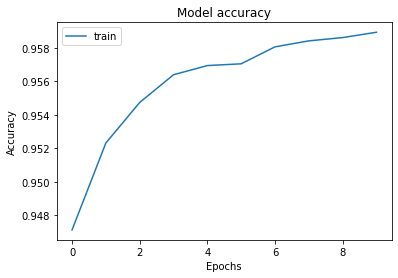

In [67]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

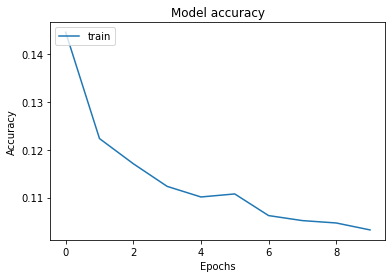

In [68]:
plt.plot(history.history['loss'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

The above graphs show increasing model accuracy and decreasing model loss over 10 epochs. Overall accuracies are high and losses are low, showing that the model is learning well. We can then evaluate performance on the validation set. 

#### Validation Set

In [46]:
model.evaluate(val_generator, steps = 100, verbose = 1)

100/100 [==============================] - 821s 8s/step - loss: 0.0938 - accuracy: 0.9762


[0.0937623530626297, 0.976190447807312]

We see that the model's predictions are consistent across the validation set. However, since in the quora dataset, we have a lot more samples belonging to class 0 (sincere) than class 1 (insincere), we need to check other metrics of performance such as sensitivity and specificity, in addition to overall accuracy. 

## Confusion Matrix

We plotted our confusion matrix using a sample from the validation data, because our data generator was very slow when operating on the entire validation set. We used stratified train-test split on the validation set, such that the average proportions of examples in each class were still an adequate representation of the larger dataset. 

In [23]:
val_data_1, val_data_2 = train_test_split(val_data, train_size=0.90, stratify = val_data['target'], random_state=42)

val_embedding = [] # generate word embeddings for validation sample
for question in val_data_2["question_text"]:
    val_embedding.append(glove_embedding(question))

val_embedding = np.array(val_embedding, dtype=object)
val_embedding = pad_sequences(val_embedding, padding = 'post', dtype = 'float32', maxlen = 100) # embedded data
val_labels = np.array(val_data_2["target"], dtype='int32') # corresponding labels

In [24]:
print(val_data_1.shape)
print(val_data_1['target'].value_counts())
print(val_data_2.shape)
print(val_data_2['target'].value_counts())

(188082, 3)
0    176445
1     11637
Name: target, dtype: int64
(20898, 3)
0    19605
1     1293
Name: target, dtype: int64


In [ ]:
keras.models.load_model("lstm_model")

We can then make predictions on this sample of the validation data, determine which class they belong to, and use the confusion matrix to compare these predictions to the true labels in the dataset.

In [24]:
predictions_val = model.predict(val_embedding, verbose = 0)

In [25]:
# Since we used sigmoid actviations, we can use a probability >= 0.5 as class 1, and < 0.5 as class 0. 
predictions = []

for i in range(len(predictions_val)):
    if predictions_val[i] < 0.5:
        predictions.append(0)
    else:
        predictions.append(1)

In [26]:
from sklearn.metrics import accuracy_score
accuracy_score(val_data_2["target"], predictions)

0.95674227198775

#### Create and visualize confusion matrix

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(val_labels, predictions)
cm

array([[19326,   279],
       [  625,   668]])

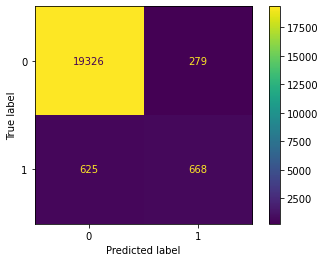

In [88]:
ConfusionMatrixDisplay(cm).plot()

We can calculate metrics from the confusion matrix, using the followng formulae: <br>
Sensitivity (true positives / all actual positives) = TP / TP + FN <br>
Specificity (true negatives / all actual negatives) =TN / TN + FP

In [38]:
# sensitivity
cm.diagonal()[1]/cm.sum(axis=1)[1]

0.5166279969064191

In [42]:
# specificity
cm.diagonal()[0]/cm.sum(axis=1)[0]

0.9857689364957919

We see that the model was better at predicting true negatives (class 0) than true positives (class 1), and this makes sense because the dataset is imbalanced, with a lot more samples in class 0. We attempt to improve sensitivity and specificity by balancing the class weights. 

### Balancing class weights

In [44]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                 classes = np.unique(train_data['target']),
                                                 y = train_data['target'])
class_weights = dict(zip(np.unique(train_data['target']), class_weights))

In [45]:
class_weights

{0: 0.5329750484252084, 1: 8.081490003480413}

In [ ]:
model = tf.keras.Sequential()

model.add((tf.keras.layers.LSTM(128,return_sequences=True)))
model.add(tf.keras.layers.GlobalMaxPool1D())
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
model.compile(optimizer = "adam", loss="binary_crossentropy", metrics=['accuracy'])

As we can see, sklearn's class_weight overweights the minority class, class 1, as compared to class 0. We can then retrain our LSTM network with balanced class weights and evaluate its performance on the validation set.

In [55]:
history = model.fit(train_generator, epochs = 10, steps_per_epoch = 1000, class_weight = class_weights, verbose = 1)

Epoch 1/10
1000/1000 [==============================] - 609s 605ms/step - loss: 0.3481 - accuracy: 0.8473
Epoch 2/10
1000/1000 [==============================] - 618s 618ms/step - loss: 0.2989 - accuracy: 0.8731
Epoch 3/10
1000/1000 [==============================] - 577s 577ms/step - loss: 0.2821 - accuracy: 0.8808
Epoch 4/10
1000/1000 [==============================] - 599s 599ms/step - loss: 0.2668 - accuracy: 0.8885
Epoch 5/10
1000/1000 [==============================] - 620s 620ms/step - loss: 0.2656 - accuracy: 0.8863
Epoch 6/10
1000/1000 [==============================] - 603s 603ms/step - loss: 0.2673 - accuracy: 0.8849
Epoch 7/10
1000/1000 [==============================] - 616s 616ms/step - loss: 0.2664 - accuracy: 0.8864
Epoch 8/10
1000/1000 [==============================] - 619s 619ms/step - loss: 0.2587 - accuracy: 0.8885
Epoch 9/10
1000/1000 [==============================] - 592s 592ms/step - loss: 0.2482 - accuracy: 0.8941
Epoch 10/10
1000/1000 [=======================

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs = 10, steps_per_epoch = 1000, class_weight = class_weights, verbose = 1)

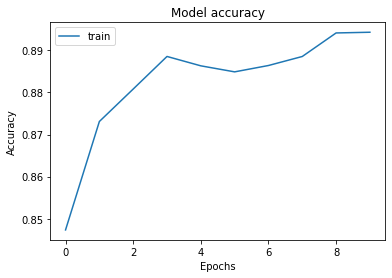

In [56]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

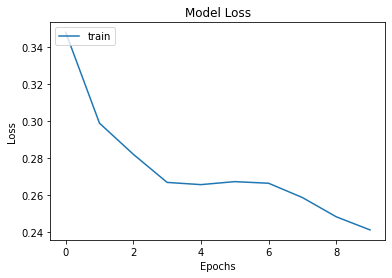

In [57]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train'], loc='upper left')
plt.show()

In [60]:
# make predictions on validation set
predictions_val = model.predict(val_embedding, verbose = 0)

In [ ]:
predictions = []
for i in range(len(predictions_val)):
    if predictions_val[i] < 0.5:
        predictions.append(0)
    else:
        predictions.append(1)

In [61]:
# validation accuracy
accuracy_score(val_data_2["target"], predictions)

0.8798928127093502

In [62]:
cm = confusion_matrix(val_labels, predictions)
cm

array([[17203,  2402],
       [  108,  1185]])

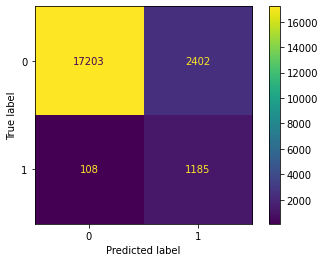

In [63]:
ConfusionMatrixDisplay(cm).plot()

In [65]:
# sensitivity
cm.diagonal()[1]/cm.sum(axis=1)[1]

0.9164733178654292

In [66]:
# specificity
cm.diagonal()[0]/cm.sum(axis=1)[0]

0.8774802346340219

With balanced class weights, we see that overall accuracy decreases to the late 80s instead of the late 90s, however performance improved on other metrics. While specificity decreased slightly to 87%, sensitivity increased from 51% to 91%, showing that model became better at predicting the minority class after overweighting, which was the goal. The decrease in overall accuracy and specificity to account for this increase in sensitivity further emphasizes the trade-offs that are often made between different performance metrics when training a deep neural network. 

## BERT
As a second training approach, we used the transformer model BERT. We started by downloading the BERT model and tokenizer from Tensorflow hub.

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as tf_hub
import pandas as pd
from tensorflow import keras
import sys
sys.path.append('models')
from official.nlp import optimization
from official.nlp.bert import tokenization
from official.nlp.data import classifier_data_lib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math

### Loading BERT
Getting the bert layer from tensorflow hub

In [3]:
bert_encoder = tf_hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable=True)
vocab_file = bert_encoder.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_encoder.resolved_object.do_lower_case.numpy()
bert_tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

### Importing Data
We read in the files in the same way as the LSTM model, and use train_test_split() to create train, validation and test sets. 

In [4]:
df = pd.read_csv("/home/DAVIDSON/brwiedenbeck/public/NLP/quora.csv")

In [5]:
train_data, test_data = train_test_split(df, train_size=0.80, stratify = df['target'], random_state=42)
train_data, val_data = train_test_split(train_data, train_size=0.80, stratify = train_data['target'], random_state=42)

In [6]:
train_data, _ = train_test_split(train_data, train_size=0.001, stratify = train_data['target'], random_state=42)

We then put the data into a dataset using the from_tensor_slices method, which returns a dataset of tuples in the form: (question text, label).

In [10]:
train_data = tf.data.Dataset.from_tensor_slices((train_data['question_text'].values, train_data['target'].values))
val_data = tf.data.Dataset.from_tensor_slices((val_data['question_text'].values, val_data['target'].values))

### Preprocessing
We need to convert the data into a form that is usable by BERT. Doing so requires transforming each point in the dataset to input_word_ids (tokensfor the input text string), input_mask (padding mask) and input_type_ids (here, a vector of zeroes because it is a classification task). We can map this transformation to the entire dataset using a second function, preprocess_map(). 

In [7]:
def preprocess(question, label, label_list = [0,1], max_seq_length = 200, tokenizer = bert_tokenizer):
   
    datapoint = classifier_data_lib.InputExample(guid = None, text_a = question.numpy(), text_b = None, label = label.numpy())
    processed_question = classifier_data_lib.convert_single_example(0, datapoint, label_list, max_seq_length, tokenizer)

    return (processed_question.input_ids, processed_question.input_mask, processed_question.segment_ids, processed_question.label_id)


In [8]:
def preprocess_map(question, label):
    input_ids, input_mask, segment_ids, label_id = tf.py_function(preprocess, inp=[question, label], Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

    input_ids.set_shape([200])
    input_mask.set_shape([200])
    segment_ids.set_shape([200])
    label_id.set_shape([])

    dictionary = {'input_word_ids': input_ids, 'input_mask': input_mask, 'input_type_ids': segment_ids}
    
    return (dictionary, label_id) # dictionary contains input_word_ids, input_mask, input_type_ids for dataset


In [9]:
batch_size = 256
def train_gen(train_data):
    while True:
        num_batches = math.ceil(len(train_data) / batch_size)
        for i in range(num_batches):
            batch = train_data.iloc[i * batch_size: (i + 1) * batch_size] # extract one batch 
            batch = tf.data.Dataset.from_tensor_slices((train_data['question_text'].values, train_data['target'].values))
            batch = (batch.map(preprocess_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .shuffle(1000)
                          .batch(32, drop_remainder=True))
            batch = list(batch)
        yield batch[0]

In [10]:
train_generator = train_gen(train_data)

In [ ]:
val_data = (val_data.map(preprocess_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            .batch(32, drop_remainder=True)) 

### Model
We can now feed the preprocessed text to the model. We have three input layers, one for each preprocessing output, the bert encoder layer from which we select the pooled output, a dropout layer and an output layer to make predictions. The BERT authors recommend a learning rate of 2e-5, so we can then comepile and train our model using a learning rate of 2e-5 for 10 epochs. 

In [11]:
input_word_ids = tf.keras.layers.Input(shape=(200,), dtype=tf.int32, name="input_word_ids")


input_mask = tf.keras.layers.Input(shape=(200,), dtype=tf.int32, name="input_mask")


input_type_ids = tf.keras.layers.Input(shape=(200,), dtype=tf.int32, name="input_type_ids")

pooled_output, sequence_output = bert_encoder([input_word_ids, input_mask, input_type_ids])

dropped = tf.keras.layers.Dropout(0.3, name = "dropout")(pooled_output)
output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(dropped)

model = tf.keras.Model(
      inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids}, 
        outputs=output)

In [12]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-5),
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

In [ ]:
history = model.fit(train_generator, verbose = 1, epochs=5)


Epoch 1/5


### Citations
GloVe embeddings and introduction to LSTM: https://www.kaggle.com/code/stacykurnikova/using-glove-embedding <br>
Implementing BERT: https://www.youtube.com/watch?v=D9yyt6BfgAM <br>
Preprocessing BERT: https://github.com/anantgupta129/NLP-with-BERT-for-Quora-Insincere-Questions-Dataset/blob/main/NLP_with_BERT.ipynb <br>
